In [16]:
import sklearn
import numpy as np

from sklearn import datasets
from sklearn import preprocessing
from sklearn.model_selection import train_test_split as split 
import pandas as pd

import missingno as msno
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import LabelEncoder

In [17]:
df = pd.read_csv('Titanic-Dataset.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [18]:
le_sex = LabelEncoder()
le_em = LabelEncoder()
le_deck = LabelEncoder()

df = df.drop(columns=['Name', 'Ticket', 'PassengerId'])
df['Age'] = df['Age'].fillna(int(df['Age'].median()))


df['Sex'] = le_sex.fit_transform(df['Sex'])

df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
df['Embarked'] = df['Embarked'].apply(lambda x: x if x in ['S', 'C'] else 'Q')
df['Embarked'] = le_em.fit_transform(df['Embarked'])

def age_group(age):
    if age <= 12:
        return 0
    elif age <= 18:
        return 1
    elif age <= 60:
        return 2
    else:
        return 3 

df['AgeGroup'] = df['Age'].apply(age_group)
df = df.drop('Age', axis=1)

df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['FarePerPerson'] = df['Fare'] / df['FamilySize']
df['IsAlone'] = df['FamilySize'].apply(lambda x: 1 if x == 1 else 0)

df['Deck'] = df['Cabin'].apply(lambda x: str(x)[0] if pd.notna(x) else 'U')
df['Deck'] = le_deck.fit_transform(df['Deck'])
df = df.drop('Cabin', axis=1)

df['AgeClass'] = df['AgeGroup'] * df['Pclass']

In [19]:
df

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,AgeGroup,FamilySize,FarePerPerson,IsAlone,Deck,AgeClass
0,0,3,1,1,0,7.2500,2,2,2,3.62500,0,8,6
1,1,1,0,1,0,71.2833,0,2,2,35.64165,0,2,2
2,1,3,0,0,0,7.9250,2,2,1,7.92500,1,8,6
3,1,1,0,1,0,53.1000,2,2,2,26.55000,0,2,2
4,0,3,1,0,0,8.0500,2,2,1,8.05000,1,8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,0,0,13.0000,2,2,1,13.00000,1,8,4
887,1,1,0,0,0,30.0000,2,2,1,30.00000,1,1,2
888,0,3,0,1,2,23.4500,2,2,4,5.86250,0,8,6
889,1,1,1,0,0,30.0000,0,2,1,30.00000,1,2,2


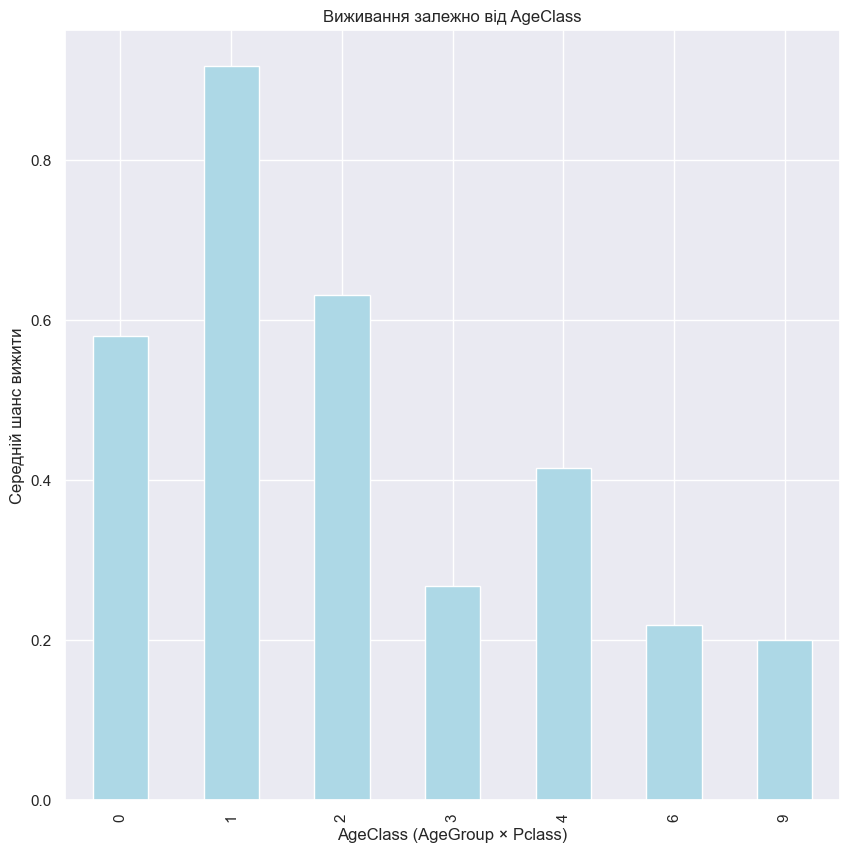

In [21]:
# Від віку і классу (Pclass) виживають чи ні

ageclass_survival = df.groupby('AgeClass')['Survived'].mean()
ageclass_survival.plot(kind='bar', color='lightblue')
plt.ylabel('Середній шанс вижити')
plt.xlabel('AgeClass (AgeGroup × Pclass)')
plt.title('Виживання залежно від AgeClass')
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_4768\3764921389.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fare_survival = df.groupby('FareGroup')['Survived'].mean()


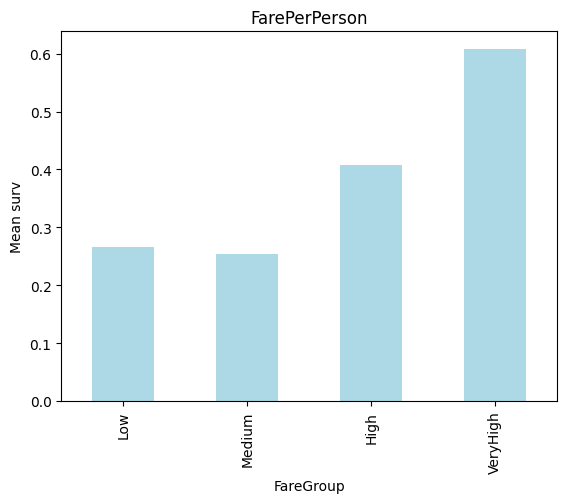

In [6]:
# Ціна більша - то більший шанс - довести це

df['FareGroup'] = pd.qcut(df['FarePerPerson'], 4, labels=['Low', 'Medium', 'High', 'VeryHigh'])
fare_survival = df.groupby('FareGroup')['Survived'].mean()

fare_survival.plot(kind='bar', color='lightblue')
plt.ylabel('Mean surv')
plt.title('FarePerPerson')
plt.show()

<Axes: >

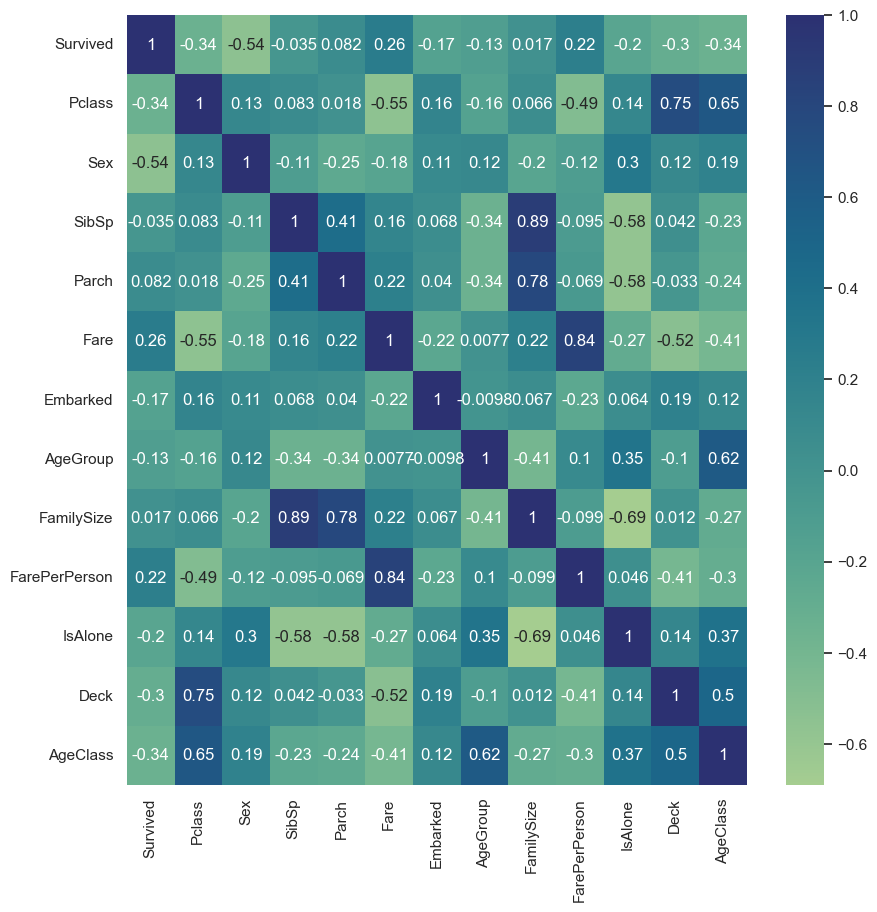

In [7]:
# SibSp Parch - подивитись на кореляції між всіма числовими ознаками і подумати які краще обьеднувати які ні
# 0.41

corr = df.corr(numeric_only=True)
sn.set(rc={
    "figure.figsize": (10, 10)
})
sn.heatmap(corr, annot=True, cmap="crest")

In [8]:
df_train, df_test = split(df, test_size=0.2, shuffle=True, random_state=11)

In [9]:
y = df['Survived']
X = df.drop('Survived', axis=1)

In [10]:
X_train = df_train[["Pclass", "Sex", "SibSp", "Parch", "FarePerPerson", "Embarked", "AgeGroup", "FamilySize", "Deck", "IsAlone", "AgeClass", "Fare"]] 
y_train = df_train['Survived'] 
X_test = df_test[["Pclass", "Sex", "SibSp", "Parch", "FarePerPerson", "Embarked", "AgeGroup", "FamilySize", "Deck", "IsAlone", "AgeClass", "Fare"]] 
y_test = df_test['Survived']

In [11]:
df

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,AgeGroup,FamilySize,FarePerPerson,IsAlone,Deck,AgeClass,FareGroup
0,0,3,1,1,0,7.2500,2,2,2,3.62500,0,8,6,Low
1,1,1,0,1,0,71.2833,0,2,2,35.64165,0,2,2,VeryHigh
2,1,3,0,0,0,7.9250,2,2,1,7.92500,1,8,6,Medium
3,1,1,0,1,0,53.1000,2,2,2,26.55000,0,2,2,VeryHigh
4,0,3,1,0,0,8.0500,2,2,1,8.05000,1,8,6,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,0,0,13.0000,2,2,1,13.00000,1,8,4,High
887,1,1,0,0,0,30.0000,2,2,1,30.00000,1,1,2,VeryHigh
888,0,3,0,1,2,23.4500,2,2,4,5.86250,0,8,6,Low
889,1,1,1,0,0,30.0000,0,2,1,30.00000,1,2,2,VeryHigh


In [12]:
scaler = preprocessing.MinMaxScaler()
cols_to_scale = ["FarePerPerson", "Fare"]
X_train.loc[:, cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test.loc[:, cols_to_scale] = scaler.transform(X_test[cols_to_scale])

In [13]:
model = SVC()
model.fit(X_train, y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [14]:
predictions = model.predict(X_test)
print(classification_report(y_test, predictions, digits=4, zero_division=0))

              precision    recall  f1-score   support

           0     0.9000    0.9153    0.9076       118
           1     0.8305    0.8033    0.8167        61

    accuracy                         0.8771       179
   macro avg     0.8653    0.8593    0.8621       179
weighted avg     0.8763    0.8771    0.8766       179

